In [24]:
import bisect

import matplotlib
import netCDF4
import shapely.geometry
import rasterio
import cmocean.cm
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np
import pyugrid
import tqdm

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.style
# matplotlib.style.use('ggplot')

%matplotlib inline

Read raster

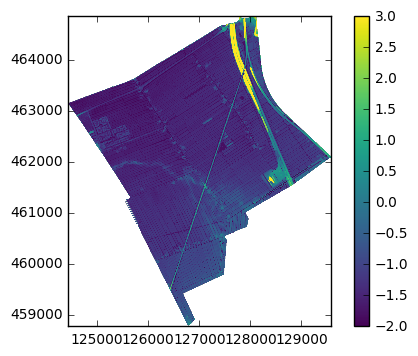

In [2]:
# original bathymetry with burned streams
# with rasterio.open('dem_3Di_2272015.tif') as src:
#     dem = src.read(1, masked=True)
with rasterio.open('AHN2_FM.tif') as src:
    dem = src.read(1, masked=True)
    
domain = dem.min(), dem.max()
vmax = 20 # np.max(np.abs(domain))
# 1/3 of the map is 
vmin = -1/2*vmax
vmin = -2
vmax = 3

# pixel sizes
dxp = src.affine.a
dyp = -src.affine.e

extent = rasterio.plot.plotting_extent(src)
plt.imshow(
    dem[::10, ::10], 
    cmap=matplotlib.cm.viridis, 
    vmin=vmin, 
    vmax=vmax,
    extent=extent
    
)
plt.colorbar()




Read grid

In [3]:
filename = './1d2d_map.nc'
t = 0

(462500, 463200)

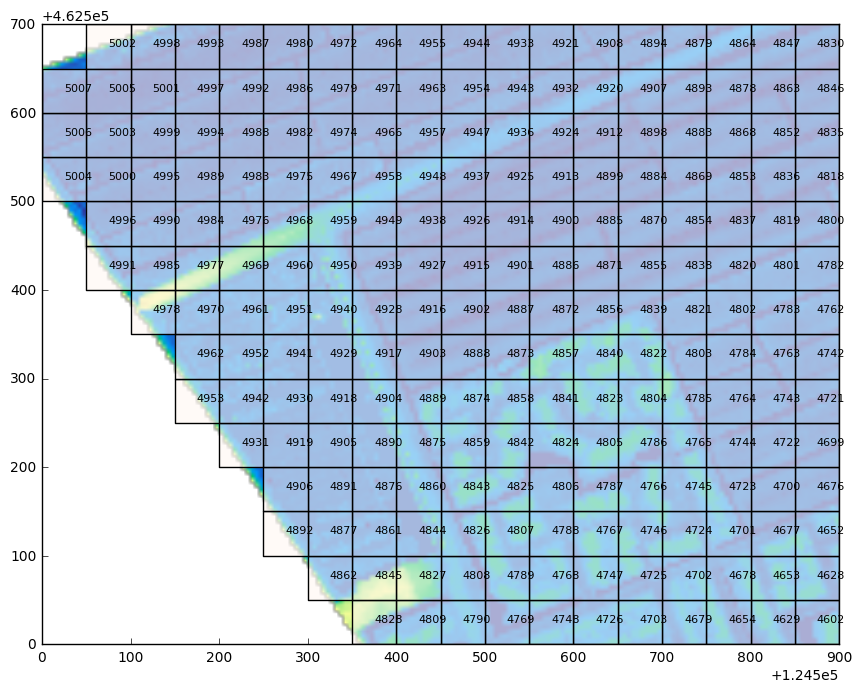

In [4]:
ugrid = pyugrid.UGrid.from_ncfile(filename, 'mesh2d')
faces = ugrid.faces
face_centers = ugrid.face_coordinates
nodes = ugrid.nodes
face_coordinates = nodes[faces]


ds = netCDF4.Dataset(filename)
s1 = ds.variables['mesh2d_s1'][t]
hs = ds.variables['mesh2d_waterdepth'][t]
vol = ds.variables['mesh2d_vol1'][t]
domain = s1.min(), s1.max()
domain = hs.min(), hs.max()
N = matplotlib.colors.Normalize(*domain)
colors = matplotlib.cm.RdPu(N(hs))
colors[hs < 0.03, 3] = 0.1
colors[:, 3] = 0.6

extent = rasterio.plot.plotting_extent(src)

polys = matplotlib.collections.PolyCollection(verts=face_coordinates, facecolors=colors, edgecolors='black')
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(
    dem[::10, ::10], 
    cmap=matplotlib.cm.terrain, 
    vmin=vmin, 
    vmax=vmax,
    extent=extent   
)
ax.add_collection(polys)
ax.autoscale()
#x = np.array([(list(x) + [None]) for x in face_coordinates[...,0]]).flat
# y = np.array([(list(y) + [None]) for y in face_coordinates[...,1]]).flat
# ax.fill(x, y, data=hs, edgecolor='none')
bounds_x = 124500, 125400
bounds_y = 462500, 463200
for i, xy in enumerate(face_centers):
    if bounds_x[0] < xy[0] < bounds_x[1] and bounds_y[0] < xy[1] < bounds_y[1]:
        ax.text(xy[0], xy[1], str(i), fontsize=8)
ax.set_xlim(*bounds_x)
ax.set_ylim(*bounds_y)

 Compute volume relocation
 
 Cell volume -> pixel cumalitive volume (over threshold)
 cell 4701

(100, 100)


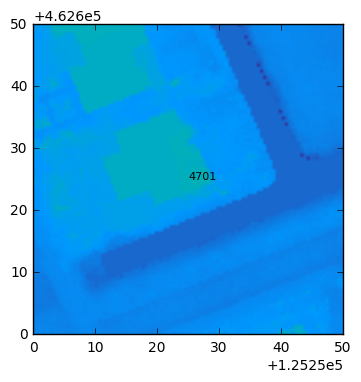

In [5]:
def data_for_idx(face_idx, correction=0):
    face = face_coordinates[face_idx]
    idx = (face - (src.affine.xoff, src.affine.yoff)) / (src.affine.a, src.affine.e)
    i_min, i_max = int(idx[:,0].min()), int(idx[:,0].max()) 
    j_min, j_max = int(idx[:,1].min()), int(idx[:,1].max()) 
    dem_i = dem[j_min:j_max, i_min:i_max]
    vol_i = vol[face_idx] + correction
    data = dict(
        face=face,
        dem=dem_i,
        vol=vol_i
    )
    return data

data = data_for_idx(4701)
dem_i = data['dem']
face = data['face']
print(dem_i.shape)
fig, ax = plt.subplots()
extent = [
    face[:,0].min(), 
    face[:,0].max(), 
    face[:,1].min(), 
    face[:,1].max()
]
ax.imshow(
    dem_i,
    cmap=matplotlib.cm.terrain, 
    vmin=-2.5, 
    vmax=5,
    extent=extent
)

bounds_x = extent[0], extent[1]
bounds_y = extent[2], extent[3]
for i, xy in enumerate(face_centers):
    if bounds_x[0] < xy[0] < bounds_x[1] and bounds_y[0] < xy[1] < bounds_y[1]:
        ax.text(xy[0], xy[1], str(i), fontsize=8)



In [30]:
# compute cache of histograms per cell
face_ids = range(faces.shape[0])

hist_cache = {}
for face_idx in tqdm.tqdm_notebook(face_ids):
    data = data_for_idx(face_idx)
    n, bins = np.histogram(dem_i.flatten(), bins='auto')
    volume_table = np.abs(src.affine.a * src.affine.e) * n * np.diff(bins)
    cum_volume_table = np.cumsum(volume_table)
    hist_cache[face_idx] = dict(
        volume_table=volume_table,
        cum_volume_table=cum_volume_table,
        n=n,
        bins=bins
    )


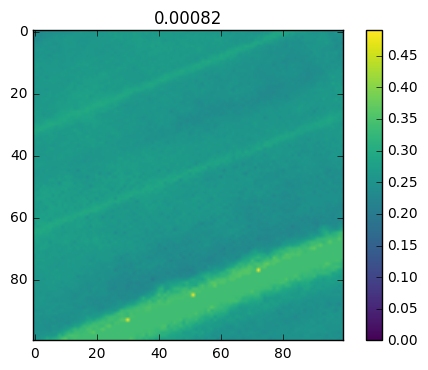

In [32]:
def vol_correction(face_idx=(4701-100, 4701+100), correction=(0, 2000)): 
    data_i = data_for_idx(face_idx, correction=correction)
    hist = hist_cache[face_idx]
    volume_table = hist["volume_table"]
    cum_volume_table = hist["cum_volume_table"]
    
    dem_i = data_i['dem']
    face = data_i['face']
    
    
    # this part is once volume is known
    vol_i = data_i['vol']
    fill_idx = bisect.bisect(cum_volume_table, vol_i)
    remaining_volume = vol_i - cum_volume_table[fill_idx - 1]
    face_area = np.prod(dem_i.shape) * dxp * dyp
    if fill_idx >= len(cum_volume_table):
        remaining = (vol_i - cum_volume_table[-1]) / face_area 
        target_level = bins[-1] + remaining
    else:
        remaining_volume_fraction = remaining_volume / volume_table[fill_idx]
        target_level = bins[fill_idx] + remaining_volume_fraction * (bins[fill_idx + 1] - bins[fill_idx])



    # first cell that is not completely filled

    vol_dem = np.zeros_like(dem_i)
    idx = dem_i < target_level
    vol_dem[idx] = (target_level - dem_i[idx]) * (dxp * dyp)
    return vol_dem


def plot_vol(face_idx=(4701-100, 4701+100), correction=(0, 2000)):
    import time
    tic = time.time()
    vol_dem = vol_correction(face_idx, correction)
    toc = time.time()
    plt.imshow(vol_dem, cmap='viridis', vmin=0)    
    plt.title("%.5f" % (toc - tic))
    plt.colorbar()
_ = interact(plot_vol)

Problems

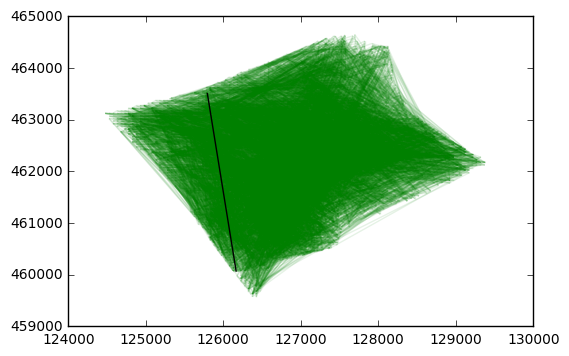

In [7]:
ugrid = pyugrid.UGrid.from_ncfile(filename, mesh_name='mesh1d')
vol = ds.variables['mesh1d_vol1'][t]
segments = ugrid.nodes[ugrid.edges]
N = matplotlib.colors.Normalize(vol.min(), vol.max())
colors = matplotlib.cm.viridis(N(vol))
fig, ax = plt.subplots()

lines = matplotlib.collections.LineCollection(segments, edgecolor='green', alpha=0.1)
ax.add_collection(lines)
lines = matplotlib.collections.LineCollection(segments[212:213,...], edgecolor='black')
ax.add_collection(lines)
ax.autoscale()


Improvements


In [8]:
segments[212], ugrid.edges[212], ugrid.nodes[ugrid.edges[212] ]

(array([[ 125792.6796875 ,  463521.03125   ],
        [ 126166.73064879,  460059.753063  ]]),
 array([5230, 5231], dtype=int32),
 array([[ 125792.6796875 ,  463521.03125   ],
        [ 126166.73064879,  460059.753063  ]]))